In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [25]:
# Load the datasets
train_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Train.csv')
test_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv')
validation_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Validation.csv')

In [26]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [27]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31) 
    df = add_cyclical_features(df, 'Month', 12)


In [28]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW'] 

# Applying the function to all the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)


In [29]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=1, include_bias=False)

# Apply transformation to all datasets
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']


In [30]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Ignoring negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # MAE and RMSE calculations
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse




In [31]:
# Training Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)
from joblib import dump
# Save the model to a file
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_linear_model_V3.joblib'
dump(linear_model, model_filename)

['/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_linear_model_V3.joblib']

In [32]:
from joblib import load
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_linear_model_V3.joblib'

loaded_best_model_gradient = load(model_filename)

In [33]:
# Step 9: Predict the MW values for the test dataset using the loaded model
y_test_predicted = loaded_best_model_gradient.predict(X_test_poly)

# Step 10: Calculate evaluation metrics for the test dataset
mae, mape, smape, rmse = calculate_metrics(y_test, y_test_predicted)
test_metrics = [mae, mape, smape, rmse]

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape}%")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 6.8798856089529865
Mean Absolute Percentage Error (MAPE): 14.925277580008322%
Symmetric Mean Absolute Percentage Error (sMAPE): 14.110091327278502%
Root Mean Squared Error (RMSE): 9.196249052276626


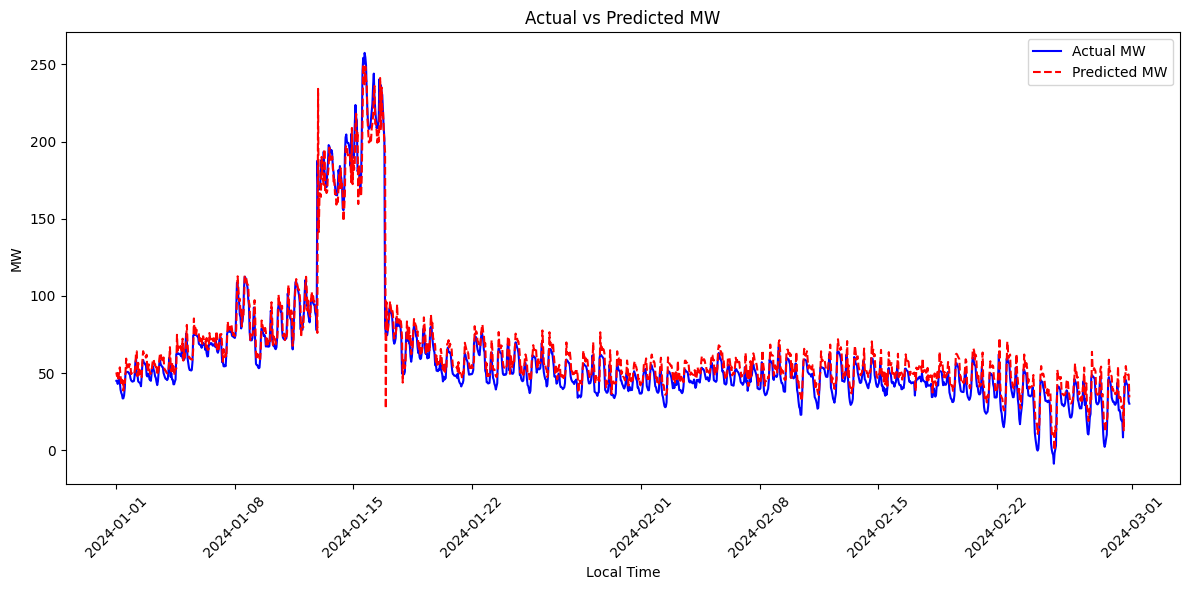

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

test_df_for_plotting = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(y_test_predicted):
    test_local_time = test_local_time[:len(y_test_predicted)]

plt.figure(figsize=(12, 6))
plt.plot(test_local_time, y_test[:len(test_local_time)], label='Actual MW', color='blue')  # Ensure y_test matches the length
plt.plot(test_local_time, y_test_predicted, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Predict MW values for the training dataset using the loaded model
y_train_predicted = loaded_best_model_gradient.predict(X_train_poly)

# Calculate evaluation metrics for the training dataset
mae_train, mape_train, smape_train, rmse_train = calculate_metrics(y_train, y_train_predicted)

print("Training Dataset Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_train}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_train}%")
print(f"Root Mean Squared Error (RMSE): {rmse_train}\n")

# Predict MW values for the validation dataset using the loaded model
y_validation_predicted = loaded_best_model_gradient.predict(X_validation_poly)

# Calculate evaluation metrics for the validation dataset
mae_validation, mape_validation, smape_validation, rmse_validation = calculate_metrics(y_validation, y_validation_predicted)

print("Validation Dataset Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_validation}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_validation}%")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_validation}%")
print(f"Root Mean Squared Error (RMSE): {rmse_validation}\n")


Training Dataset Evaluation:
Mean Absolute Error (MAE): 7.41814652386913
Mean Absolute Percentage Error (MAPE): 11.3596003757706%
Symmetric Mean Absolute Percentage Error (sMAPE): 11.37713473335433%
Root Mean Squared Error (RMSE): 18.525235723331825

Validation Dataset Evaluation:
Mean Absolute Error (MAE): 8.90214441313848
Mean Absolute Percentage Error (MAPE): 21.36077931159486%
Symmetric Mean Absolute Percentage Error (sMAPE): 19.182324824441807%
Root Mean Squared Error (RMSE): 14.260387772969493



In [36]:
print(f"Number of features: {len(feature_names)}")


Number of features: 11


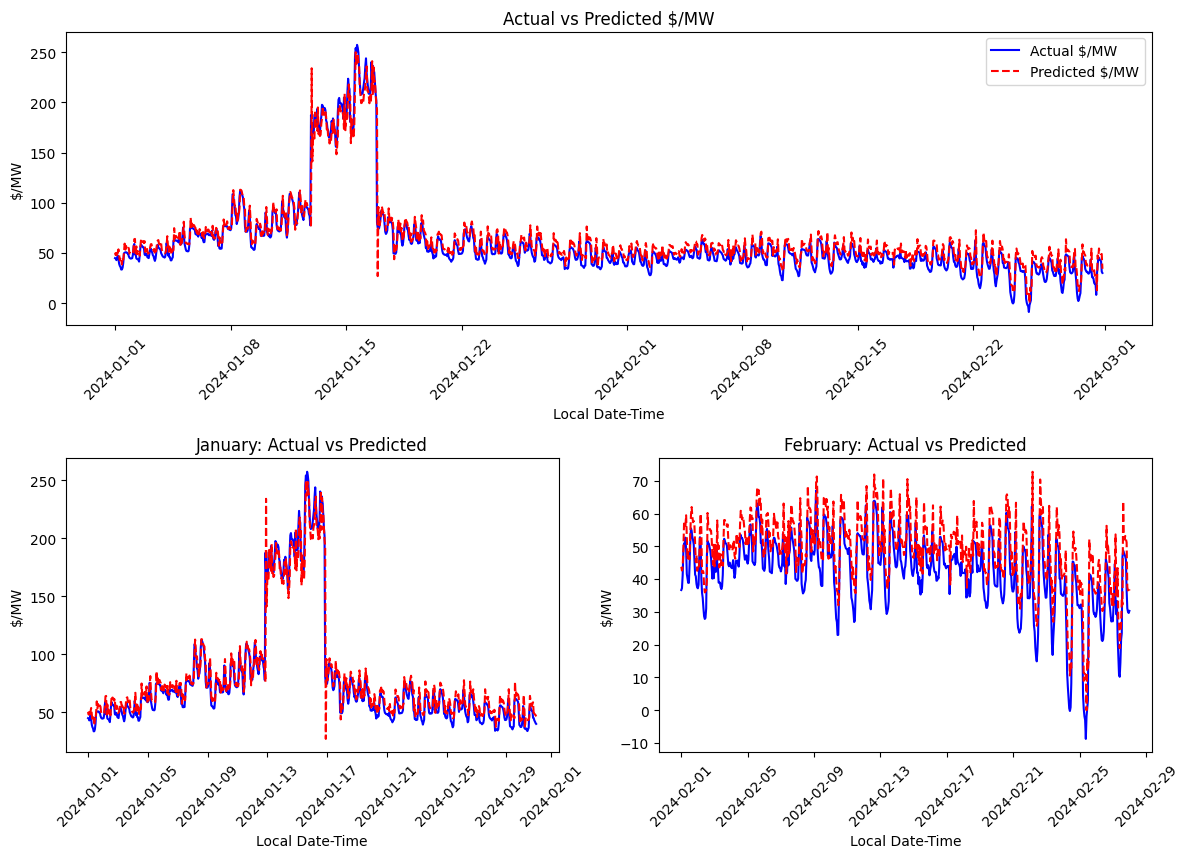

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = y_test_predicted[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = y_test_predicted[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)  # Define a grid of 3 rows and 2 columns

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])  # This subplot takes up the first row
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, y_test_predicted, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Date-Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Date-Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Date-Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()

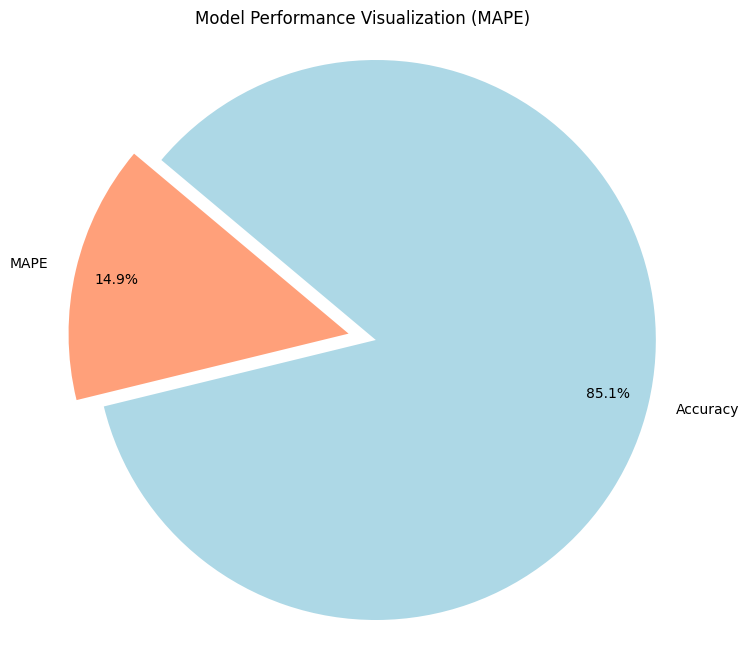

In [38]:
import matplotlib.pyplot as plt

# Assuming test_metrics is structured as [MAE, MAPE, sMAPE, RMSE]
mape = mape
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)  # Only explode the MAPE slice

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()


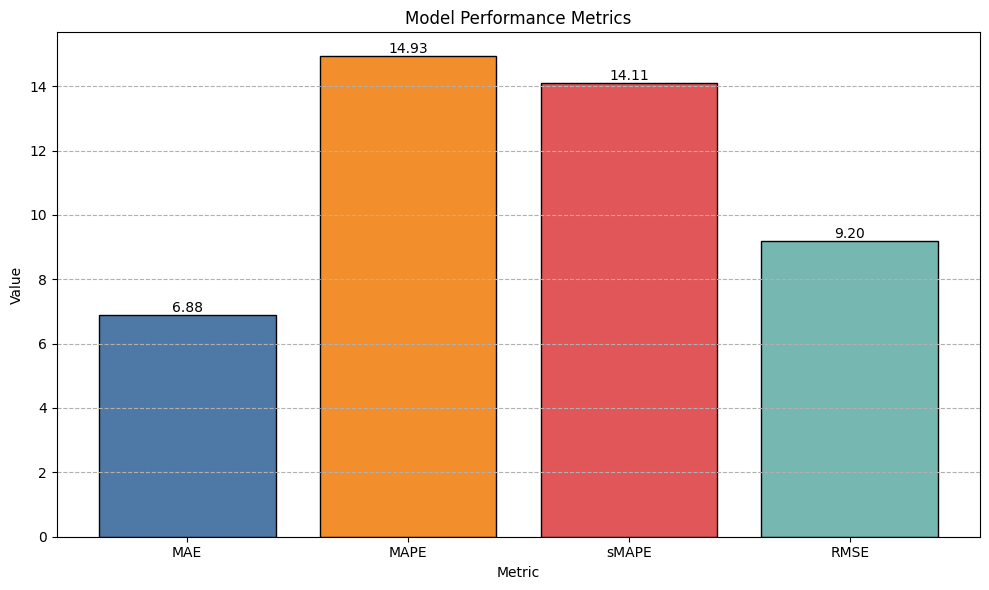

In [39]:
import matplotlib.pyplot as plt
import numpy as np

metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']
x_pos = np.arange(len(metrics_names))

plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')
plt.xticks(x_pos, metrics_names)

# Adding labels and title
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')

# Adding metric values above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
